# NEMO CF Demo with GYRE dataset

## Target structure

### Naming of the dims

```
           |       |
 j  y_r  - F - V - F -
           |       |
 j  y_c    U   T   U
           |       |
j-1 y_r  - F - V - F -
           |       |

          x_r x_c x_r
          
          i-1  i   i
```

### Final datasets

```
<xarray.Dataset>
Dimensions:            (time: 72, depth_c: 31, depth_l: y_c: 22, y_r: 22, 31 x_c: 32, x_r: 32)
Coordinates:
  * time               (time) object ...
  * depth_l            (depth_l) float32 ...
  * depth_c            (depth_c) float32 ...
    glamt              (y_c, x_c) float32 ...
    gphit              (y_c, x_c) float32 ...
    glamu              (y_c, x_r) float32 ...
    gphiu              (y_c, x_r) float32 ...
    glamv              (y_r, x_c) float32 ...
    gphiv              (y_r, x_c) float32 ...
    glamf              (y_r, x_r) float32 ...
    gphif              (y_r, x_r) float32 ...
    tmask              (depth_c, y_c, x_c) bool ...
    umask              (depth_c, y_c, x_r) bool ...
    vmask              (depth_c, y_r, x_c) bool ...
    fmask              (depth_c, y_r, x_r) bool ...
    tmaskutil          (y_c, x_c) bool ...
    umaskutil          (y_c, x_r) bool ...
    vmaskutil          (y_r, x_c) bool ...
    fmaskutil          (y_r, x_r) bool ...    
    e1t                (y_c, x_c) float64 ...
    e1u                (y_c, x_r) float64 ...
    e1v                (y_r, x_c) float64 ...
    e1f                (y_r, x_r) float64 ...
    e2t                (y_c, x_c) float64 ...
    e2u                (y_c, x_r) float64 ...
    e2v                (y_r, x_c) float64 ...
    e2f                (y_r, x_r) float64 ...
    ff                 (y_r, x_r) float64 ...
    mbathy             (y_c, x_c) int16 ...
    misf               (y_c, x_c) int16 ...
    isfdraft           (y_c, x_c) float32 ...
    e3t_1d             (depth_c) float64 ...
    e3w_1d             (depth_l) float64 ...
Dimensions without coordinates: x_c, x_r, y_c, y_r
Data variables:
    votemper           (time, depth_c, y_c, x_c) float32 ...
    vosaline           (time, depth_c, y_c, x_c) float32 ...
    sosstsst           (time, y_c, x_c) float32 ...
    sosaline           (time, y_c, x_c) float32 ...
    sossheig           (time, y_c, x_c) float32 ...
    sowaflup           (time, y_c, x_c) float32 ...
    sorunoff           (time, y_c, x_c) float32 ...
    sosfldow           (time, y_c, x_c) float32 ...
    sosst_cd           (time, y_c, x_c) float32 ...
    sosss_cd           (time, y_c, x_c) float32 ...
    sohefldo           (time, y_c, x_c) float32 ...
    soshfldo           (time, y_c, x_c) float32 ...
    somixhgt           (time, y_c, x_c) float32 ...
    somxl010           (time, y_c, x_c) float32 ...
    soicecov           (time, y_c, x_c) float32 ...
    sowindsp           (time, y_c, x_c) float32 ...
    sohefldp           (time, y_c, x_c) float32 ...
    sowafldp           (time, y_c, x_c) float32 ...
    sosafldp           (time, y_c, x_c) float32 ...
    sobowlin           (y_c, x_c) float32 ...
    vozocrtx           (time, depth_c, y_c, x_r) float32 ...
    sozotaux           (time, y_c, x_r) float32 ...
    vomecrty           (time, depth_c, y_r, x_c) float32 ...
    sometauy           (time, y_r, x_c) float32 ...
    vovecrtz           (time, depth_l, y_c, x_c) float32 ...
    votkeavt           (time, depth_l, y_c, x_c) float32 ...
    votkeavm           (time, depth_l, y_c, x_c) float32 ...
```

`depth_l` and `depth_c` are always positive downward.

## Strategy

1. Open un-decoded datasets.

2. Completely annotate aux dataset (mesh_mask and, if present, newmask_glo)
  - CF attributes (`"standard name"`, `"long_name"`, `"unit"`, ...)
  - `"coordinates"` attribute (e.g., `"gdept_1d gphit glamt"`)
  - `"nemo_cf_hgrid"` (one of `["t", "u", "v", "f"]`) and `"nemo_cf_vgrid"` (one of `["t", "w"]`)
  
3. If there's a singleton time dim / coord in the aux datasets, completely remove them (squeeze and drop!).

3. Detect horizontal and vertical grids for all data variables of the other fields
  - based on dims and by comparing the `"depth?"` and `"nav_lat"`, `"nav_lon"` fields in the same dataset to the fields from the aux dataset
  - store in attrs `"nemo_cf_hgrid"` and `"nemo_cf_vgrid"`

4. Drop `"nav_lat"`, `"nav_lon"` etc. from the data fields.

5. Rename dims (per variable) to `"x_t"`, ..., `"y_t"`, ..., `"z_t"`, ...

6. Consolidate dim names to `"x_c"`, `"x_r"`, `"y_c"`, ...

7. Fix calendars?

8. Merge everything together.

9. xr.decode_cf

10. Rename dims / coords
  - gdep?_1d --> depth_c, depth_l
  - time_counter --> time

11. Consolidate masks (using the ?maskutil fields) and drop columns.  (Not sure this is possible for general grids? At least it would need complete loading of the surface slice of each mask.)

10. Generate xgcm grid

## Parameters

In [1]:
# parameters
esm_vfc_data_dir = "../esm-vfc-data/"
nemo_catalog_url = "https://raw.githubusercontent.com/ESM-VFC/esm-vfc-catalogs/master/catalogs/NEMO_GYRE_Test.yaml"

## Tech preamble

In [2]:
import numpy as np
import xarray as xr

In [3]:
# set up intake catalog
import intake
from esmvfc_cattools import download_zenodo_files_for_entry
import os

os.environ["ESM_VFC_DATA_DIR"] = esm_vfc_data_dir

## Load catalog, fetch data, open raw T, U, V, W, and aux files

In [4]:
model_data_cat = intake.open_catalog(nemo_catalog_url)
list(model_data_cat)

['NEMO_GYRE_Test_grid_T',
 'NEMO_GYRE_Test_grid_U',
 'NEMO_GYRE_Test_grid_V',
 'NEMO_GYRE_Test_grid_W',
 'NEMO_GYRE_Test_mesh_mask']

In [5]:
# for entry in model_data_cat:
#     print(str(entry))
#     download_zenodo_files_for_entry(model_data_cat[entry], force_download=False)

In [6]:
data_ds = {k: v(xarray_kwargs={"decode_cf": False}).read() for k, v in model_data_cat.items() if "mesh_mask" not in k}
print(data_ds.keys())

aux_ds = {k: v(xarray_kwargs={"decode_cf": False}).read() for k, v in model_data_cat.items() if k not in data_ds}
print(aux_ds.keys())

dict_keys(['NEMO_GYRE_Test_grid_T', 'NEMO_GYRE_Test_grid_U', 'NEMO_GYRE_Test_grid_V', 'NEMO_GYRE_Test_grid_W'])
dict_keys(['NEMO_GYRE_Test_mesh_mask'])


## Annotate the aux data

This is _the_ critical part. With a proper and un-ambiguous description of the model grid, we can automatically detect all we need to know about the data files.

We'll get parts of the current state of `nemo_cf`.

In [7]:
%pip install -e /work/nemo_cf/ --upgrade

Obtaining file:///work/nemo_cf
  Attempting uninstall: nemo-cf
    Found existing installation: nemo-cf 0.1.0
    Uninstalling nemo-cf-0.1.0:
      Successfully uninstalled nemo-cf-0.1.0
  Running setup.py develop for nemo-cf
Note: you may need to restart the kernel to use updated packages.


In [8]:
from nemo_cf.nemo_cf import update_mesh_mask_dataset

In [9]:
update_mesh_mask_dataset??

Signature:
update_mesh_mask_dataset(
    dataset,
    attrs={'glamt': {'long_name': 'longitude of T-grid points', 'units': 'degrees_east', 'standard_name': 'longitude', 'nemo_cf_hgrid': 't'}, 'glamu': {'long_name': 'longitude of U-grid points', 'units': 'degrees_east', 'standard_name': 'longitude', 'nemo_cf_hgrid': 'u'}, 'glamv': {'long_name': 'longitude of V-grid points', 'units': 'degrees_east', 'standard_name': 'longitude', 'nemo_cf_hgrid': 'v'}, 'glamf': {'long_name': 'longitude of F-grid points', 'units': 'degrees_east', 'standard_name': 'longitude', 'nemo_cf_hgrid': 'f'}, 'gphit': {'long_name': 'latitude of T-grid points', 'units': 'degrees_north', 'standard_name': 'latitude', 'nemo_cf_hgrid': 't'}, 'gphiu': {'long_name': 'latitude of U-grid points', 'units': 'degrees_north', 'standard_name': 'latitude', 'nemo_cf_hgrid': 'u'}, 'gphiv': {'long_name': 'latitude of V-grid points', 'units': 'degrees_north', 'standard_name': 'latitude', 'nemo_cf_hgrid': 'v'}, 'gphif': {'long_name': 'l

In [10]:
import nemo_cf.cf_attributes

In [11]:
nemo_cf.cf_attributes??

Type:        module
String form: <module 'nemo_cf.cf_attributes' from '/work/nemo_cf/nemo_cf/cf_attributes.py'>
File:        /work/nemo_cf/nemo_cf/cf_attributes.py
Source:     
"""Attributes used in the annotation."""

mesh_mask_attrs = {}

# longitude fields
mesh_mask_attrs.update(
    {
        f"glam{hgrid}": {
            "long_name": f"longitude of {hgrid.upper()}-grid points",
            "units": "degrees_east",
            "standard_name": "longitude",
            "nemo_cf_hgrid": hgrid,
        }
        for hgrid in ["t", "u", "v", "f"]
    }
)

# latitude fields
mesh_mask_attrs.update(
    {
        f"gphi{hgrid}": {
            "long_name": f"latitude of {hgrid.upper()}-grid points",
            "units": "degrees_north",
            "standard_name": "latitude",
            "nemo_cf_hgrid": hgrid,
        }
        for hgrid in ["t", "u", "v", "f"]
    }
)

# depth fields
mesh_mask_attrs.update(
    {
        f"gdep{vgrid}_1d": {
            "long_name": f"depth of {vgrid.up

In [12]:
from nemo_cf.cf_attributes import mesh_mask_attrs

In [13]:
display(mesh_mask_attrs)

{'glamt': {'long_name': 'longitude of T-grid points',
  'units': 'degrees_east',
  'standard_name': 'longitude',
  'nemo_cf_hgrid': 't'},
 'glamu': {'long_name': 'longitude of U-grid points',
  'units': 'degrees_east',
  'standard_name': 'longitude',
  'nemo_cf_hgrid': 'u'},
 'glamv': {'long_name': 'longitude of V-grid points',
  'units': 'degrees_east',
  'standard_name': 'longitude',
  'nemo_cf_hgrid': 'v'},
 'glamf': {'long_name': 'longitude of F-grid points',
  'units': 'degrees_east',
  'standard_name': 'longitude',
  'nemo_cf_hgrid': 'f'},
 'gphit': {'long_name': 'latitude of T-grid points',
  'units': 'degrees_north',
  'standard_name': 'latitude',
  'nemo_cf_hgrid': 't'},
 'gphiu': {'long_name': 'latitude of U-grid points',
  'units': 'degrees_north',
  'standard_name': 'latitude',
  'nemo_cf_hgrid': 'u'},
 'gphiv': {'long_name': 'latitude of V-grid points',
  'units': 'degrees_north',
  'standard_name': 'latitude',
  'nemo_cf_hgrid': 'v'},
 'gphif': {'long_name': 'latitude of 

In [14]:
aux_ds["NEMO_GYRE_Test_mesh_mask"]

<xarray.Dataset>
Dimensions:       (t: 1, x: 32, y: 22, z: 31)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    nav_lat       (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    nav_lev       (z) float32 4.9752655 15.096427 ... 4150.2812 4451.2593
    time_counter  (t) float64 0.0
    tmask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    umask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    vmask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    fmask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    tmaskutil     (t, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    umaskutil     (t, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    vmaskutil     (t, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    fmaskutil     (t, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    glamt         (t, y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    glamu         (t, y, x) float32 -71.18203 -70.50799 ... -65.11561 -64.44156
    glamv         (t, y, x) float32 -71.85608 -71.18203 ... -65.78966 -65.11561
    glamf         (t, y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    gphit         (t, y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    gphiu         (t, y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphiv         (t, y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphif         (t, y, x) float32 15.519056 16.193104 ... 49.895462 50.569508
    e1t           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1u           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1v           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1f           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2t           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2u           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2v           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2f           (t, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    ff            (t, y, x) float64 3.89e-05 4.04e-05 ... 0.0001154 0.0001169
    mbathy        (t, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    misf          (t, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    isfdraft      (t, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    gdept_1d      (t, z) float64 4.975 15.1 25.54 ... 4.15e+03 4.451e+03
    gdepw_1d      (t, z) float64 0.0 10.0 20.27 ... 3.7e+03 4e+03 4.301e+03
    e3t_1d        (t, z) float64 10.0 10.26 10.65 11.22 ... 300.0 300.7 301.2
    e3w_1d        (t, z) float64 9.904 10.12 10.43 10.9 ... 299.5 300.4 301.0
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  27/09/2018 13:52:14 +0200

In [15]:
aux_ds["NEMO_GYRE_Test_mesh_mask"] = aux_ds["NEMO_GYRE_Test_mesh_mask"].rename({"t": "time_counter"})
aux_ds["NEMO_GYRE_Test_mesh_mask"]

<xarray.Dataset>
Dimensions:       (time_counter: 1, x: 32, y: 22, z: 31)
Dimensions without coordinates: time_counter, x, y, z
Data variables:
    nav_lon       (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    nav_lat       (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    nav_lev       (z) float32 4.9752655 15.096427 ... 4150.2812 4451.2593
    time_counter  (time_counter) float64 0.0
    tmask         (time_counter, z, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    umask         (time_counter, z, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    vmask         (time_counter, z, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    fmask         (time_counter, z, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    tmaskutil     (time_counter, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    umaskutil     (time_counter, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    vmaskutil     (time_counter, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    fmaskutil     (time_counter, y, x) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    glamt         (time_counter, y, x) float32 -71.51906 -70.84501 ... -64.77859
    glamu         (time_counter, y, x) float32 -71.18203 -70.50799 ... -64.44156
    glamv         (time_counter, y, x) float32 -71.85608 -71.18203 ... -65.11561
    glamf         (time_counter, y, x) float32 -71.51906 -70.84501 ... -64.77859
    gphit         (time_counter, y, x) float32 14.84501 15.519056 ... 49.895462
    gphiu         (time_counter, y, x) float32 15.182034 15.85608 ... 50.232487
    gphiv         (time_counter, y, x) float32 15.182034 15.85608 ... 50.232487
    gphif         (time_counter, y, x) float32 15.519056 16.193104 ... 50.569508
    e1t           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    e1u           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    e1v           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    e1f           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    e2t           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    e2u           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    e2v           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    e2f           (time_counter, y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05
    ff            (time_counter, y, x) float64 3.89e-05 4.04e-05 ... 0.0001169
    mbathy        (time_counter, y, x) int16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    misf          (time_counter, y, x) int16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    isfdraft      (time_counter, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    gdept_1d      (time_counter, z) float64 4.975 15.1 ... 4.15e+03 4.451e+03
    gdepw_1d      (time_counter, z) float64 0.0 10.0 20.27 ... 4e+03 4.301e+03
    e3t_1d        (time_counter, z) float64 10.0 10.26 10.65 ... 300.7 301.2
    e3w_1d        (time_counter, z) float64 9.904 10.12 10.43 ... 300.4 301.0
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  27/09/2018 13:52:14 +0200

In [16]:
aux_ds["NEMO_GYRE_Test_mesh_mask"] = update_mesh_mask_dataset(
    aux_ds["NEMO_GYRE_Test_mesh_mask"].squeeze(drop=True),
    drop_vars=()
)
aux_ds["NEMO_GYRE_Test_mesh_mask"]

<xarray.Dataset>
Dimensions:       (x: 32, y: 22, z: 31)
Dimensions without coordinates: x, y, z
Data variables:
    nav_lon       (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    nav_lat       (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    nav_lev       (z) float32 4.9752655 15.096427 ... 4150.2812 4451.2593
    time_counter  float64 0.0
    tmask         (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    umask         (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    vmask         (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    fmask         (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    tmaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    umaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    vmaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    fmaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    glamt         (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    glamu         (y, x) float32 -71.18203 -70.50799 ... -65.11561 -64.44156
    glamv         (y, x) float32 -71.85608 -71.18203 ... -65.78966 -65.11561
    glamf         (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    gphit         (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    gphiu         (y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphiv         (y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphif         (y, x) float32 15.519056 16.193104 ... 49.895462 50.569508
    e1t           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1u           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1v           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1f           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2t           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2u           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2v           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2f           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    ff            (y, x) float64 3.89e-05 4.04e-05 ... 0.0001154 0.0001169
    mbathy        (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    misf          (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    isfdraft      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    gdept_1d      (z) float64 4.975 15.1 25.54 ... 3.85e+03 4.15e+03 4.451e+03
    gdepw_1d      (z) float64 0.0 10.0 20.27 30.92 ... 3.7e+03 4e+03 4.301e+03
    e3t_1d        (z) float64 10.0 10.26 10.65 11.22 ... 298.9 300.0 300.7 301.2
    e3w_1d        (z) float64 9.904 10.12 10.43 10.9 ... 298.2 299.5 300.4 301.0
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  27/09/2018 13:52:14 +0200

In [17]:
aux_ds["NEMO_GYRE_Test_mesh_mask"].tmask

<xarray.DataArray 'tmask' (z: 31, y: 22, x: 32)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int8)
Dimensions without coordinates: z, y, x
Attributes:
    long_name:      mask for T-grid
    flag_meanings:  land, water
    flag_values:    0, 1
    coordinates:    gdept_1d glamt gphit
    nemo_cf_hgrid:  t
    nemo_cf_vgrid:  t

In [18]:
mesh_mask = aux_ds["NEMO_GYRE_Test_mesh_mask"]
mesh_mask["tmask"] = mesh_mask["tmask"].rename({"x": "x_c", "y": "y_c", "z": "z_c"})
mesh_mask

<xarray.Dataset>
Dimensions:       (x: 32, x_c: 32, y: 22, y_c: 22, z: 31, z_c: 31)
Dimensions without coordinates: x, x_c, y, y_c, z, z_c
Data variables:
    nav_lon       (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    nav_lat       (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    nav_lev       (z) float32 4.9752655 15.096427 ... 4150.2812 4451.2593
    time_counter  float64 0.0
    tmask         (z_c, y_c, x_c) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    umask         (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    vmask         (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    fmask         (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    tmaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    umaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    vmaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    fmaskutil     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    glamt         (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    glamu         (y, x) float32 -71.18203 -70.50799 ... -65.11561 -64.44156
    glamv         (y, x) float32 -71.85608 -71.18203 ... -65.78966 -65.11561
    glamf         (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    gphit         (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    gphiu         (y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphiv         (y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphif         (y, x) float32 15.519056 16.193104 ... 49.895462 50.569508
    e1t           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1u           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1v           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1f           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2t           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2u           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2v           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2f           (y, x) float64 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    ff            (y, x) float64 3.89e-05 4.04e-05 ... 0.0001154 0.0001169
    mbathy        (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    misf          (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    isfdraft      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    gdept_1d      (z) float64 4.975 15.1 25.54 ... 3.85e+03 4.15e+03 4.451e+03
    gdepw_1d      (z) float64 0.0 10.0 20.27 30.92 ... 3.7e+03 4e+03 4.301e+03
    e3t_1d        (z) float64 10.0 10.26 10.65 11.22 ... 298.9 300.0 300.7 301.2
    e3w_1d        (z) float64 9.904 10.12 10.43 10.9 ... 298.2 299.5 300.4 301.0
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  27/09/2018 13:52:14 +0200

In [19]:
aux_ds["NEMO_GYRE_Test_mesh_mask"].time_counter.shape

()

In [20]:
def remove_singleton_time_counter(ds):
    """Remove time_counter coord which has been left over.
    
    This should go into the update function?
    """
    try:
        if ds["time_counter"].shape == ():
            return ds.drop(["time_counter", ])
        else:
            return ds
    except Exception as e:
        return ds

In [21]:
aux_ds["NEMO_GYRE_Test_mesh_mask"] = remove_singleton_time_counter(aux_ds["NEMO_GYRE_Test_mesh_mask"])
aux_ds["NEMO_GYRE_Test_mesh_mask"]

<xarray.Dataset>
Dimensions:    (x: 32, x_c: 32, y: 22, y_c: 22, z: 31, z_c: 31)
Dimensions without coordinates: x, x_c, y, y_c, z, z_c
Data variables:
    nav_lon    (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    nav_lat    (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    nav_lev    (z) float32 4.9752655 15.096427 25.536308 ... 4150.2812 4451.2593
    tmask      (z_c, y_c, x_c) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    umask      (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    vmask      (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    fmask      (z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    tmaskutil  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    umaskutil  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    vmaskutil  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    fmaskutil  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    glamt      (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    glamu      (y, x) float32 -71.18203 -70.50799 ... -65.11561 -64.44156
    glamv      (y, x) float32 -71.85608 -71.18203 ... -65.78966 -65.11561
    glamf      (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    gphit      (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
    gphiu      (y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphiv      (y, x) float32 15.182034 15.85608 ... 49.558437 50.232487
    gphif      (y, x) float32 15.519056 16.193104 ... 49.895462 50.569508
    e1t        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1u        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1v        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e1f        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2t        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2u        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2v        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    e2f        (y, x) float64 1.06e+05 1.06e+05 1.06e+05 ... 1.06e+05 1.06e+05
    ff         (y, x) float64 3.89e-05 4.04e-05 4.19e-05 ... 0.0001154 0.0001169
    mbathy     (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    misf       (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    isfdraft   (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    gdept_1d   (z) float64 4.975 15.1 25.54 ... 3.85e+03 4.15e+03 4.451e+03
    gdepw_1d   (z) float64 0.0 10.0 20.27 30.92 ... 3.7e+03 4e+03 4.301e+03
    e3t_1d     (z) float64 10.0 10.26 10.65 11.22 ... 298.9 300.0 300.7 301.2
    e3w_1d     (z) float64 9.904 10.12 10.43 10.9 ... 298.2 299.5 300.4 301.0
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  27/09/2018 13:52:14 +0200

## Grid detection

- vertical coords
    - in the data files (`..._grid_T.nc`, `..._icemod.nc`, etc.), the vertical dim is always exactly one of
    `["deptht", "depthu", "depthv", "depthf", "depthw"]`
    - in the mesh-mask files, there's two vars for the vertical axis: `["gdept_1d", "gdepw_1d"]`
    - we detect actual vertical grids by comparing `["deptht", "depthu", "depthv", "depthf", "depthw"]`
    to `["gdept_1d", "gdepw_1d"]`
    
- horizontal coords
    - in the data files (`..._grid_T.nc`, `..._icemod.nc`, etc.), there horizontal coords are always
    `["nav_lon", "nav_lat"]`
    - in the mesh-mask files, there's the latitude fields `["gphit", "gphiu", "gphiv", "gphif"]` and
    the longitude fields `["glamt", "glamu", "glamv", "glamf"]`
    - we detect actual horizontal grids by comparing `["nav_lon", "nav_lat"]` to `["gphit", "gphiu", "gphiv", "gphif"]` and
    `["glamt", "glamu", "glamv", "glamf"]`

In [22]:
def detect_horizontal_grid(ds, aux_ds):
    """Detect hgrid from nav_lon and nav_lat by comparing with the mesh_mask.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset of which the grid will be detected.
    aux_ds : xarray Dataset
        Dataset with aux data (needs all the `glam.` and `gphi.`)
    
    Returns
    -------
    str : Name of horizontal grid (one of "t", "u", "v", "f")
    
    """
    # TODO: Make sure to also handle coordinates if they are already in 'coords'.
    tol = min(
        abs(aux_ds["glamt"].diff("x")).min().data,
        abs(aux_ds["gphit"].diff("y")).min().data
    ) / 10.0
    for hgrid in ["t", "u", "v", "f"]:
        lat_diff = abs(ds["nav_lat"] - aux_ds[f"gphi{hgrid}"]).max()
        lon_diff = abs(ds["nav_lon"] - aux_ds[f"glam{hgrid}"]).max()
        if (lat_diff < tol) & (lon_diff < tol):
            return hgrid


def test_detect_horizontal_grid(x=100, y=100, coords=False):
    """Test if grid detections successfully locks in on the desired grid.
    
    (Note that this does not use any info about staggered positions
    but just creates different grids using random data.)
    
    """
    aux_ds = xr.Dataset()
    for hgrid in ["t", "u", "v", "f"]:
        for philam in ["lam", "phi"]:
            aux_ds[f"g{philam}{hgrid}"] = xr.DataArray(
                np.random.normal(size=(y, x)),
                dims=("y", "x")
            )
    if coords:
        aux_ds = aux_ds.set_coords(
            [v for v in aux_ds.data_vars if v.startswith("g")]
        )
        
    for hgrid in ["t", "u", "v", "f"]:
        ds = xr.Dataset()
        ds["nav_lon"] = aux_ds[f"glam{hgrid}"]
        ds["nav_lat"] = aux_ds[f"gphi{hgrid}"]
        if coords:
            ds = ds.set_coords(["nav_lon", "nav_lat"])
        assert detect_horizontal_grid(ds, aux_ds) == hgrid
        
test_detect_horizontal_grid(coords=False)
test_detect_horizontal_grid(coords=True)

In [23]:
def detect_vertical_grid(ds, aux_ds):
    """Detect vgrid from `depth?` by comparing with the mesh_mask.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset of which the grid will be detected.
    aux_ds : xarray Dataset
        Dataset with aux data (needs both of the `gdep._1d`)
    
    Returns
    -------
    str : Name of vertical grid (one of "t", "w")
    
    """
    tol = abs(aux_ds["gdept_1d"].diff("z")).min().data / 10.0
    depth_coord = [k for k in ds.coords if "depth" in k][0]
    for vgrid in ["t", "w"]:
        z_diff = (abs(ds[depth_coord].data) - abs(aux_ds[f"gdep{vgrid}_1d"].data)).var()
        if z_diff < tol:
            return vgrid

        
def test_detect_vertical_grid(z=30, coords=False):
    """Test if grid detections successfully locks in on the desired grid.
    
    (Note that this does not use any info about staggered positions
    but just creates different grids using random data.)
    
    """
    aux_ds = xr.Dataset()
    for vgrid in ["t", "w"]:
        aux_ds[f"gdep{vgrid}_1d"] = xr.DataArray(
                20 * np.random.normal(size=(z, )) + np.linspace(0, 100, z),
                dims=("z", )
            )
    if coords:
        aux_ds = aux_ds.set_coords(
            [v for v in aux_ds.data_vars if v.startswith("gdep")]
        )
        
    for vgrid in ["t", "w"]:
        ds = xr.Dataset()
        ds[f"depth{vgrid}"] = xr.DataArray(
            aux_ds[f"gdep{vgrid}_1d"].data,
            dims=(f"depth{vgrid}", )
        )
        if coords:
            ds = ds.set_coords([f"depth{vgrid}"])
        detected_vgrid = detect_vertical_grid(ds, aux_ds)
        assert detected_vgrid == vgrid
        
test_detect_vertical_grid(coords=True)
test_detect_vertical_grid(coords=False)  # Raises!

In [24]:
detect_vertical_grid(data_ds["NEMO_GYRE_Test_grid_T"], aux_ds["NEMO_GYRE_Test_mesh_mask"])

't'

In [25]:
def detect_grids(ds, aux_ds):
    """Detect grid by comparing with aux_ds.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset of which the grid will be detected.
    aux_ds : xarray Dataset
        Dataset with aux data (needs both of the `gdep._1d`)
    
    Returns
    -------
    dict : grids. Keys "hgrid" and "vgrid" indicate horizontal and
           vertical grid.

    """
    return {
        "hgrid": detect_horizontal_grid(ds, aux_ds),
        "vgrid": detect_vertical_grid(ds, aux_ds)
    }

In [26]:
grids = {k: detect_grids(data_ds[k], aux_ds["NEMO_GYRE_Test_mesh_mask"]) for k in data_ds}

In [27]:
grids

{'NEMO_GYRE_Test_grid_T': {'hgrid': 't', 'vgrid': 't'},
 'NEMO_GYRE_Test_grid_U': {'hgrid': 'u', 'vgrid': 't'},
 'NEMO_GYRE_Test_grid_V': {'hgrid': 'v', 'vgrid': 't'},
 'NEMO_GYRE_Test_grid_W': {'hgrid': 't', 'vgrid': 'w'}}

In [28]:
ar = xr.DataArray([], dims=("a", ))  #.to_dataset(name="ar")
"a" in ar.dims

True

In [29]:
def safely_rename_dims(dataset, rename_dims=None):
    """Rename dims if they are present.
    
    Parameters
    ----------
    dataset : xarray Dataset
        Dataset whose dims are to be renamed.
    rename_dims : dict
        Mapping old (keys) to new (values) names.
    
    Returns
    -------
    Xarray dataset with renamed dims.
    
    """
    valid_rename_dims = {
        dim: rename_dims[dim]
        for dim in filter(lambda dim: dim in dataset.dims, rename_dims)
    }

    return dataset.rename_dims(valid_rename_dims)


def test_safe_dim_renaming():
    ds = xr.DataArray([], dims=("a", ), name="data").to_dataset()
    rn_ds = safely_rename_dims(ds, {"a": "x"})
    assert "a" not in rn_ds.dims
    assert "x" in rn_ds.dims
    
    
test_safe_dim_renaming()

In [30]:
def safely_rename_vars(dataset, rename_vars=None):
    """Rename vars if they are present.
    
    Parameters
    ----------
    dataset : xarray Dataset
        Dataset in which dims will be renamed.
    rename_vars : dict
        Dict mapping old (keys) and new (values) names.
    
    Returns
    -------
    xarray Dataset with renamed vars.
    
    """
    valid_rename_vars = {
        var: rename_vars[var]
        for var in filter(
            lambda var: var in dataset.data_vars or var in dataset.coords,
            rename_vars
        )
    }
    return dataset.rename_vars(valid_rename_vars)


def test_safe_renaming_vars():
    ds = xr.Dataset()
    ds["asdf"] = xr.DataArray([], name="asdf")
    rn_ds = safely_rename_vars(ds, {"asdf": "POIU"})
    assert "asdf" not in rn_ds.data_vars
    assert "POIU" in rn_ds.data_vars
    

test_safe_renaming_vars()

In [31]:
def update_data_file_coords(dataset, hgrid=None, vgrid=None):
    """Ensure correct naming of spatial dims and coords.
    
    Parameters
    ----------
    dataset : xr.Dataset
        Dataset which will be updated.
    hgrid : str
        Horizontal grid name. (One of "t", "u", "v", "f".)
    vgrid : str
        Vertial grid name. (One of "t", "w".)
    
    Returns
    -------
    Xarray dataset whith updated names.
    
    The hgrid will be used to name the longitude and latitude coords.
    The vgrid will be used to name the vertical coord.
    """
    # assert grid names are lower case
    hgrid = hgrid.lower()
    vgrid = vgrid.lower()
    
    # catch error in NEMO output which calls the T-grid depths for u and v like
    # the horizontal grids
    if vgrid == "w":
        depth_name = vgrid
    else:
        depth_name = hgrid
    
    # First, construct and apply dim renaming.
    rename_dims_dict = {
        f"depth{depth_name}": f"z_{vgrid}",
        "y": f"y_{hgrid}",
        "x": f"x_{hgrid}"
    }
    dataset = safely_rename_dims(dataset, rename_dims=rename_dims_dict)

    # Then, construct and apply var (coord var) renaming.
    rename_vars_dict = {
        f"depth{depth_name}": f"gdep{vgrid}_1d",
        "nav_lat": f"gphi{hgrid}",
        "nav_lon": f"glam{hgrid}",
    }
    dataset = safely_rename_vars(dataset, rename_vars=rename_vars_dict)

    # Finally, if there's a CF-convention based "coordinates" attribute, 
    # update this as well.
    for v in dataset.data_vars:
        if "coordinates" in dataset[v].attrs:
            for old, new in rename_vars_dict.items():
                dataset[v].attrs["coordinates"] = (
                    dataset[v].attrs["coordinates"].replace(old, new)
                )

    return dataset

In [32]:
data_ds = {
    k: update_data_file_coords(
        data_ds[k],
        **detect_grids(data_ds[k], aux_ds["NEMO_GYRE_Test_mesh_mask"])
    ) for k in data_ds.keys()
}

In [33]:
data_ds

{'NEMO_GYRE_Test_grid_T': <xarray.Dataset>
 Dimensions:            (tbnds: 2, time_counter: 72, x_t: 32, y_t: 22, z_t: 31)
 Coordinates:
     gdept_1d           (z_t) float32 4.9752655 15.096427 ... 4150.2812 4451.2593
   * time_counter       (time_counter) float64 2.16e+05 6.48e+05 ... 3.089e+07
 Dimensions without coordinates: tbnds, x_t, y_t, z_t
 Data variables:
     glamt              (y_t, x_t) float32 -71.51906 -70.84501 ... -64.77859
     gphit              (y_t, x_t) float32 14.84501 15.519056 ... 49.895462
     time_counter_bnds  (time_counter, tbnds) float64 0.0 4.32e+05 ... 3.11e+07
     votemper           (time_counter, z_t, y_t, x_t) float32 0.0 0.0 ... 0.0 0.0
     vosaline           (time_counter, z_t, y_t, x_t) float32 0.0 0.0 ... 0.0 0.0
     sosstsst           (time_counter, y_t, x_t) float32 0.0 0.0 0.0 ... 0.0 0.0
     sosaline           (time_counter, y_t, x_t) float32 0.0 0.0 0.0 ... 0.0 0.0
     sossheig           (time_counter, y_t, x_t) float32 0.0 0.0 0.0 ...

In [34]:
def fix_calendar(ds):
    for v in list(ds.data_vars) + list(ds.coords):
        try:
            if ds[v].attrs["calendar"] == "360d":
                ds[v].attrs["calendar"] = "360_day"
        except KeyError as e:
            pass
    return ds

In [35]:
data_ds = {
    k: fix_calendar(data_ds[k]) for k in data_ds
}

## Design choices

## Split dim name and coord name for one-dimensional coords?

I could go for this
```python
z_c = xr.DataArray([5, 15, 25], dims=("z_c", ))
z_l = xr.DataArray([0, 10, 20], dims=("z_l", ))
ds.coords["z_c"] = z_c
ds.coords["z_l"] = z_l
```
or for this
```python
z_c = xr.DataArray([0, 1, 2], dims=("z_c", ))
depth_c = xr.DataArray([5, 15, 25], dims=("z_c", ), coords={("z_c": z_c)})
z_l = xr.DataArray([-0.5, 0.5, 1.5], dims=("z_l", ))
depth_l = xr.DataArray([0, 10, 20], dims=("z_l", ), coords={("z_l": z_l)})
ds.coords["depth_c"] = depth_c
ds.coords["depth_l"] = depth_l
```

## Have redundant horizontal dims which make 

`x_c` or `x_t`, `x_u` separate?

In [36]:
def consolidate_dim_names(ds):
    """Consolidate dim names to thos reflecting C grid axis shifts.
    
    Parameters
    ----------
    ds : xr.Dataset
        Dataset whose dims are to be consolidated.
    
    Returns
    -------
    Xarray dataset with consolidated dims.
    
    """
    mapping = {
        "x_t": "x_c", "y_t": "y_c",
        "x_u": "x_r", "y_u": "y_c",
        "x_v": "x_c", "y_v": "y_r",
        "x_f": "x_r", "y_f": "y_r",
        "z_t": "z_c", "z_w": "z_l"
    }
    return safely_rename_dims(ds, rename_dims=mapping)


def add_dim_coords(ds):
    # TODO: Not sure about the 
    for dim in ds.dims:
        if dim.endswith("_c"):
            ds.coords[dim] = (
                [dim, ],
                np.arange(ds.dims[dim]),
                {
                    "axis": dim[0].upper(),
                    "c_grid_axis_shift": 0
                }
            )
        if dim.endswith("_r"):
            ds.coords[dim] = (
                [dim, ],
                np.arange(ds.dims[dim]) + 0.5,
                {
                    "axis": dim[0].upper(),
                    "c_grid_axis_shift": +0.5
                }
            )
        if dim.endswith("_l"):
            ds.coords[dim] = (
                [dim, ],
                np.arange(ds.dims[dim]) - 0.5,
                {
                    "axis": dim[0].upper(),
                    "c_grid_axis_shift": -0.5
                }
            )
    return ds

In [37]:
data_ds = {k: consolidate_dim_names(v) for k, v in data_ds.items()}

In [38]:
from xgcm import Grid

In [39]:
#TODO: Fix for mesh-mask as well.

In [40]:
grid = Grid(
    add_dim_coords(xr.decode_cf(xr.merge(data_ds.values()))),
    periodic=['X', 'Y']
)

In [41]:
grid.interp(data_ds["NEMO_GYRE_Test_grid_T"].votemper, "X", to="right")

<xarray.DataArray (time_counter: 72, z_c: 31, y_c: 22, x_r: 32)>
array([[[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 22.655497 ,
          11.321932 ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 22.587475 ,
          11.282675 ,  0.       ],
         ...,
         [11.464449 , 22.916206 , 22.888557 , ..., 22.204254 ,
          11.103953 ,  0.       ],
         [11.44692  , 22.877977 , 22.845293 , ..., 22.205658 ,
          11.101432 ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 22.650764 ,
          11.319617 ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 22.582886 ,
          11.280427 ,  0.       ],
         ...,
         [11.459047 , 22.905819 , 22.87874  , ..., 22.200848 ,
          11.102275 ,  0.       ],
         [11.441918 , 22.86812  , 22.835888 , ..., 22.202362 ,
          11.099807 ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 22.629513 ,
          11.309087 ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 22.562029 ,
          11.269997 ,  0.       ],
         ...,
         [11.436794 , 22.863113 , 22.839382 , ..., 22.187677 ,
          11.095707 ,  0.       ],
         [11.420938 , 22.827372 , 22.797522 , ..., 22.189548 ,
          11.093468 ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        ...,

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  4.0012584,
           2.0006292,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  4.001258 ,
           2.0006292,  0.       ],
         ...,
         [ 2.0006285,  4.001257 ,  4.0012574, ...,  4.001258 ,
           2.000629 ,  0.       ],
         [ 2.0006282,  4.001257 ,  4.001257 , ...,  4.0012584,
           2.0006292,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  4.0005336,
           2.0002668,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  4.0005336,
           2.0002668,  0.       ],
         ...,
         [ 2.0002666,  4.000533 ,  4.000533 , ...,  4.0005336,
           2.0002668,  0.       ],
         [ 2.0002666,  4.000533 ,  4.000533 , ...,  4.0005336,
           2.0002668,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]]],


       [[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 21.926483 ,
          10.95209  ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ..., 21.763466 ,
          10.858448 ,  0.       ],
 

In [42]:
whole_ds = xr.merge(
    list(map(xr.Dataset.reset_coords, data_ds.values())) + list(map(xr.Dataset.reset_coords, aux_ds.values())),
    compat="override"
)
whole_ds = xr.decode_cf(whole_ds)
print(whole_ds)

<xarray.Dataset>
Dimensions:            (tbnds: 2, time_counter: 72, x: 32, x_c: 32, x_r: 32, y: 22, y_c: 22, y_r: 22, z: 31, z_c: 31, z_l: 31)
Coordinates:
    glamt              (y_c, x_c) float32 ...
    gphit              (y_c, x_c) float32 ...
    gdept_1d           (z_c) float32 ...
  * time_counter       (time_counter) object 0001-01-03 12:00:00 ... 0001-12-28 12:00:00
    glamu              (y_c, x_r) float32 ...
    gphiu              (y_c, x_r) float32 ...
    glamv              (y_r, x_c) float32 ...
    gphiv              (y_r, x_c) float32 ...
    gdepw_1d           (z_l) float32 ...
    glamf              (y, x) float32 ...
    gphif              (y, x) float32 ...
Dimensions without coordinates: tbnds, x, x_c, x_r, y, y_c, y_r, z, z_c, z_l
Data variables:
    time_counter_bnds  (time_counter, tbnds) object ...
    votemper           (time_counter, z_c, y_c, x_c) float32 ...
    vosaline           (time_counter, z_c, y_c, x_c) float32 ...
    sosstsst           (time_coun

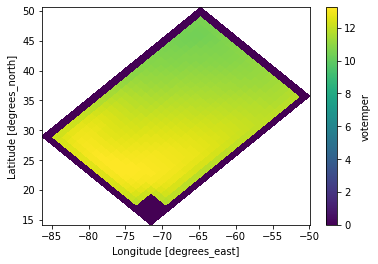

In [43]:
whole_ds.votemper.mean(dim=["time_counter", "z_c"]).plot.pcolormesh(x="glamt", y="gphit")

In [44]:
whole_ds.fmaskutil.sum(), whole_ds.fmask.isel(z=0).sum()

(<xarray.DataArray 'fmaskutil' ()>
 array(542), <xarray.DataArray 'fmask' ()>
 array(542))

In [45]:
whole_ds.umask

<xarray.DataArray 'umask' (z: 31, y: 22, x: 32)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 1, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 1, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 1, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int8)
Coordinates:
    glamf    (y, x) float32 ...
    gphif    (y, x) float32 ...
Dimensions without coordinates: z, y, x
Attributes:
    long_name:      mask for U-grid
    flag_meanings:  land, water
    flag_values:    0, 1
    nemo_cf_hgrid:  u
    nemo_cf_vgrid:  t

In [46]:
whole_ds.attrs["grid"] = grid

In [47]:
whole_ds

<xarray.Dataset>
Dimensions:            (tbnds: 2, time_counter: 72, x: 32, x_c: 32, x_r: 32, y: 22, y_c: 22, y_r: 22, z: 31, z_c: 31, z_l: 31)
Coordinates:
    glamt              (y_c, x_c) float32 ...
    gphit              (y_c, x_c) float32 ...
    gdept_1d           (z_c) float32 ...
  * time_counter       (time_counter) object 0001-01-03 12:00:00 ... 0001-12-28 12:00:00
    glamu              (y_c, x_r) float32 ...
    gphiu              (y_c, x_r) float32 ...
    glamv              (y_r, x_c) float32 ...
    gphiv              (y_r, x_c) float32 ...
    gdepw_1d           (z_l) float32 ...
    glamf              (y, x) float32 ...
    gphif              (y, x) float32 ...
Dimensions without coordinates: tbnds, x, x_c, x_r, y, y_c, y_r, z, z_c, z_l
Data variables:
    time_counter_bnds  (time_counter, tbnds) object ...
    votemper           (time_counter, z_c, y_c, x_c) float32 ...
    vosaline           (time_counter, z_c, y_c, x_c) float32 ...
    sosstsst           (time_counter, y_c, x_c) float32 ...
    sosaline           (time_counter, y_c, x_c) float32 ...
    sossheig           (time_counter, y_c, x_c) float32 ...
    sowaflup           (time_counter, y_c, x_c) float32 ...
    sorunoff           (time_counter, y_c, x_c) float32 ...
    sosfldow           (time_counter, y_c, x_c) float32 ...
    sosst_cd           (time_counter, y_c, x_c) float32 ...
    sosss_cd           (time_counter, y_c, x_c) float32 ...
    sohefldo           (time_counter, y_c, x_c) float32 ...
    soshfldo           (time_counter, y_c, x_c) float32 ...
    somixhgt           (time_counter, y_c, x_c) float32 ...
    somxl010           (time_counter, y_c, x_c) float32 ...
    soicecov           (time_counter, y_c, x_c) float32 ...
    sowindsp           (time_counter, y_c, x_c) float32 ...
    sohefldp           (time_counter, y_c, x_c) float32 ...
    sowafldp           (time_counter, y_c, x_c) float32 ...
    sosafldp           (time_counter, y_c, x_c) float32 ...
    sobowlin           (y_c, x_c) float32 ...
    vozocrtx           (time_counter, z_c, y_c, x_r) float32 ...
    sozotaux           (time_counter, y_c, x_r) float32 ...
    vomecrty           (time_counter, z_c, y_r, x_c) float32 ...
    sometauy           (time_counter, y_r, x_c) float32 ...
    vovecrtz           (time_counter, z_l, y_c, x_c) float32 ...
    votkeavt           (time_counter, z_l, y_c, x_c) float32 ...
    votkeavm           (time_counter, z_l, y_c, x_c) float32 ...
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
    nav_lev            (z) float32 ...
    tmask              (z_c, y_c, x_c) int8 ...
    umask              (z, y, x) int8 ...
    vmask              (z, y, x) int8 ...
    fmask              (z, y, x) int8 ...
    tmaskutil          (y, x) int8 ...
    umaskutil          (y, x) int8 ...
    vmaskutil          (y, x) int8 ...
    fmaskutil          (y, x) int8 ...
    e1t                (y, x) float64 ...
    e1u                (y, x) float64 ...
    e1v                (y, x) float64 ...
    e1f                (y, x) float64 ...
    e2t                (y, x) float64 ...
    e2u                (y, x) float64 ...
    e2v                (y, x) float64 ...
    e2f                (y, x) float64 ...
    ff                 (y, x) float64 ...
    mbathy             (y, x) int16 ...
    misf               (y, x) int16 ...
    isfdraft           (y, x) float32 ...
    e3t_1d             (z) float64 ...
    e3w_1d             (z) float64 ...
Attributes:
    grid:     <xgcm.Grid>\nX Axis (periodic):\n  * center   x_c --> right\n  ...

In [48]:
whole_ds.nbytes / 1e6

48.029476

In [49]:
import cloudpickle

In [50]:
pckl = cloudpickle.dumps(whole_ds)

In [51]:
len(pckl)

48092689

In [52]:
whole_ds_unpickled = cloudpickle.loads(pckl)
whole_ds_unpickled

<xarray.Dataset>
Dimensions:            (tbnds: 2, time_counter: 72, x: 32, x_c: 32, x_r: 32, y: 22, y_c: 22, y_r: 22, z: 31, z_c: 31, z_l: 31)
Coordinates:
    glamt              (y_c, x_c) float32 ...
    gphit              (y_c, x_c) float32 ...
    gdept_1d           (z_c) float32 ...
  * time_counter       (time_counter) object 0001-01-03 12:00:00 ... 0001-12-28 12:00:00
    glamu              (y_c, x_r) float32 ...
    gphiu              (y_c, x_r) float32 ...
    glamv              (y_r, x_c) float32 ...
    gphiv              (y_r, x_c) float32 ...
    gdepw_1d           (z_l) float32 ...
    glamf              (y, x) float32 ...
    gphif              (y, x) float32 ...
Dimensions without coordinates: tbnds, x, x_c, x_r, y, y_c, y_r, z, z_c, z_l
Data variables:
    time_counter_bnds  (time_counter, tbnds) object ...
    votemper           (time_counter, z_c, y_c, x_c) float32 ...
    vosaline           (time_counter, z_c, y_c, x_c) float32 ...
    sosstsst           (time_counter, y_c, x_c) float32 ...
    sosaline           (time_counter, y_c, x_c) float32 ...
    sossheig           (time_counter, y_c, x_c) float32 ...
    sowaflup           (time_counter, y_c, x_c) float32 ...
    sorunoff           (time_counter, y_c, x_c) float32 ...
    sosfldow           (time_counter, y_c, x_c) float32 ...
    sosst_cd           (time_counter, y_c, x_c) float32 ...
    sosss_cd           (time_counter, y_c, x_c) float32 ...
    sohefldo           (time_counter, y_c, x_c) float32 ...
    soshfldo           (time_counter, y_c, x_c) float32 ...
    somixhgt           (time_counter, y_c, x_c) float32 ...
    somxl010           (time_counter, y_c, x_c) float32 ...
    soicecov           (time_counter, y_c, x_c) float32 ...
    sowindsp           (time_counter, y_c, x_c) float32 ...
    sohefldp           (time_counter, y_c, x_c) float32 ...
    sowafldp           (time_counter, y_c, x_c) float32 ...
    sosafldp           (time_counter, y_c, x_c) float32 ...
    sobowlin           (y_c, x_c) float32 ...
    vozocrtx           (time_counter, z_c, y_c, x_r) float32 ...
    sozotaux           (time_counter, y_c, x_r) float32 ...
    vomecrty           (time_counter, z_c, y_r, x_c) float32 ...
    sometauy           (time_counter, y_r, x_c) float32 ...
    vovecrtz           (time_counter, z_l, y_c, x_c) float32 ...
    votkeavt           (time_counter, z_l, y_c, x_c) float32 ...
    votkeavm           (time_counter, z_l, y_c, x_c) float32 ...
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
    nav_lev            (z) float32 ...
    tmask              (z_c, y_c, x_c) int8 ...
    umask              (z, y, x) int8 ...
    vmask              (z, y, x) int8 ...
    fmask              (z, y, x) int8 ...
    tmaskutil          (y, x) int8 ...
    umaskutil          (y, x) int8 ...
    vmaskutil          (y, x) int8 ...
    fmaskutil          (y, x) int8 ...
    e1t                (y, x) float64 ...
    e1u                (y, x) float64 ...
    e1v                (y, x) float64 ...
    e1f                (y, x) float64 ...
    e2t                (y, x) float64 ...
    e2u                (y, x) float64 ...
    e2v                (y, x) float64 ...
    e2f                (y, x) float64 ...
    ff                 (y, x) float64 ...
    mbathy             (y, x) int16 ...
    misf               (y, x) int16 ...
    isfdraft           (y, x) float32 ...
    e3t_1d             (z) float64 ...
    e3w_1d             (z) float64 ...
Attributes:
    grid:     <xgcm.Grid>\nX Axis (periodic):\n  * center   x_c --> right\n  ...